# We will start with some EDA to understand the data input we have.

* calculating the length of text
* counting the commas and period
* calculating the length to commas ratio
* counting the numberic number used

In [1]:
# Packages
import pandas as pd
import numpy  as np

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly

# ML Libaries
import tensorflow as tf
import sklearn
# below is taken from deep note example: https://deepnote.com/@joshzwiebel/Using-the-transformers-library-e34c35b3-eeb8-4706-962c-57341bd0dafe
# import tensorflow_hub as hub
# from transformers.modeling_tf_openai import TFOpenAIGPTLMHeadModel #this is the GPT transformer with additional layers added for easy language modeling
# from transformers.tokenization_openai import OpenAIGPTTokenizer
# import simpletransformers

import string

from sklearn.feature_extraction.text import CountVectorizer

2022-12-06 04:42:43.069999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 04:42:43.188112: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 04:42:43.191789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 04:42:43.191806: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
#EDA
train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

df_train = train.sample(frac=0.90, random_state = 2022)
df_dev = train.drop(df_train.index)
print(df_train.shape)
print(df_dev.shape)


(3520, 8)
(391, 8)


In [3]:
df_train['length'] = df_train['full_text'].str.len()
df_train.head()
df_train.length.describe()

count    3520.000000
mean     2327.665341
std      1024.806308
min        82.000000
25%      1593.750000
50%      2172.500000
75%      2860.750000
max      6044.000000
Name: length, dtype: float64

The length of the full_text range from 2.3K to 6K, with a mean of 2.3K (STD = 1K). 

In [4]:
df_train.length.mean()

2327.665340909091

In [21]:


df_1 = _deepnote_execute_sql("""SELECT vocabulary, COUNT(*) FROM df_train
GROUP BY vocabulary
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_1

vocabulary  count_star()
0         3.0          1362
1         3.5           918
2         2.5           471
3         2.0           110
4         4.0           506
5         4.5           104
6         1.5            11
7         5.0            36
8         1.0             2

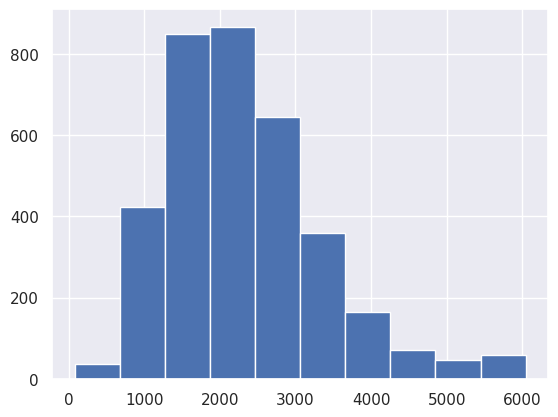

In [5]:
hist = df_train.length.hist(bins=10)

It looks pretty much the length are around 2-3K. With CNN we might be padding them with zeros. 

/tmp/ipykernel_310/2871841652.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  , mask=np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

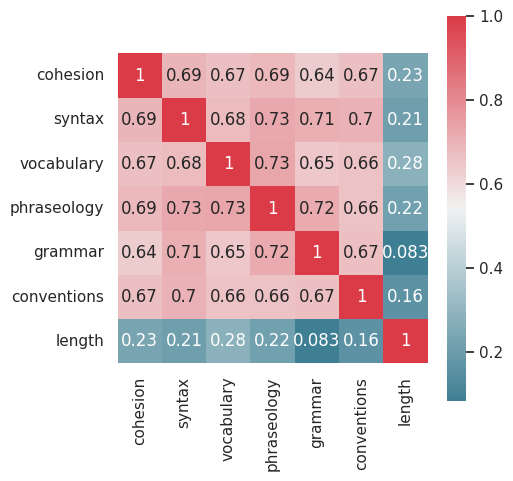

In [6]:
corr = df_train.drop(['full_text'], axis=1).corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr
            , mask=np.zeros_like(corr, dtype=np.bool)
            , cmap=sns.diverging_palette(220, 10, as_cmap=True)
            , square=True, ax=ax
            , annot=True)

The length does not suggest significant (defined as .8)correlation with ourput variables, with a highest corr with *vocabulary* (.28) and lowest corr with *grammar* (.089)

In [7]:
df_train['comma_count'] = df_train.full_text.str.count(',')
df_train['period_count'] = df_train.full_text.str.count('\.')
df_train.head(10)

text_id                                          full_text  \
3354  E7F9A77683D2  I would pick policy 1 because lunch is free ti...   
2994  D6930DD4EDD0  Knowing what your future career is in high sch...   
3345  E792CBEB06C5  I think that students should bring phones to s...   
987   4BA9296EBE9F  A topic that is debated is if students should ...   
2004  9760A1CB4336  Everyone has a talent or a skill. But they are...   
2075  9C1A3F53B869  Do you think that should be students finish hi...   
2954  D42B99110E5C  I want to work at a supreme store for a day in...   
387   1D75D76AC202  Dear Principal,\n\nI was thinking about the po...   
1148  5902C2E86345  Is influencing others other even a good? I bel...   
1848  8B1D74DDA04B  well people has deferent opinion's about commu...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  length  \
3354       2.5     2.5         3.0          3.0      3.5          3.0     968   
2994       3.5     3.5         3.5          3.5      4.0          3.5    1293   
3345       3.5     3.0         3.0          2.5      3.0          3.0    1054   
987        3.5     2.5         3.0          3.0      2.5          3.5    2339   
2004       2.5     3.0         3.0          3.0      3.0          3.0    1606   
2075       3.5     3.0         3.0          2.5      2.5          3.5    2332   
2954       2.5     2.0         3.0          3.0      2.5          2.5    4190   
387        3.0     3.5         3.5          3.5      4.0          4.0    1489   
1148       3.0     3.0         2.5          3.0      2.0          3.0    2238   
1848       2.0     1.5         2.0          2.0      2.0          1.0     825   

      comma_count  period_count  
3354            2             8  
2994            2            13  
3345            2             7  
987             2            24  
2004           11            28  
2075           26            18  
2954            0            38  
387             4            13  
1148            1            24  
1848            0             0

In [8]:
DeepnoteChart(df_train, """{"mark":{"type":"bar","tooltip":true},"$schema":"https://vega.github.io/schema/vega-lite/v4.json","encoding":{"x":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

/tmp/ipykernel_310/2871841652.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  , mask=np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

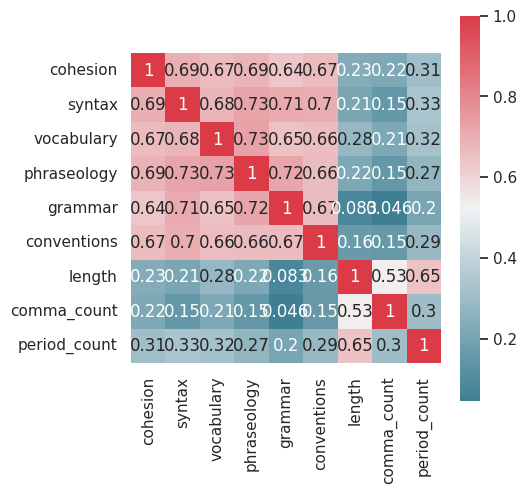

In [9]:
corr = df_train.drop(['full_text'], axis=1).corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr
            , mask=np.zeros_like(corr, dtype=np.bool)
            , cmap=sns.diverging_palette(220, 10, as_cmap=True)
            , square=True, ax=ax
            , annot=True)

In [10]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english')) ## is unordered, cannot be changed and does not allowe duplicates.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


So the period count and commas counts are not having significant value to predict the six output metrics.

In [11]:
corpus = []

full_text = df_train['full_text'].str.split()
full_text = full_text.values.tolist()
print(full_text[1][1:5])
print(len(full_text))

corpus = [word for i in full_text for word in i]

print(len(corpus))
print(corpus[:5])

from collections import defaultdict
dic = defaultdict(int)

for word in corpus:
    if word in stopwords:
        dic[word] += 1

['what', 'your', 'future', 'career']
3520
1511876
['I', 'would', 'pick', 'policy', '1']


<BarContainer object of 10 artists>

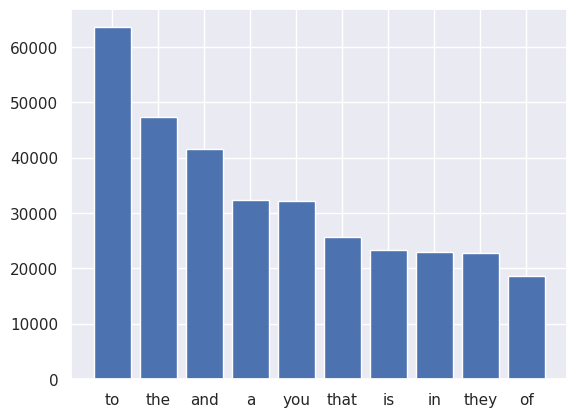

In [12]:
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]
x, y = list(zip(*top))
plt.bar(x,y)

<AxesSubplot: >

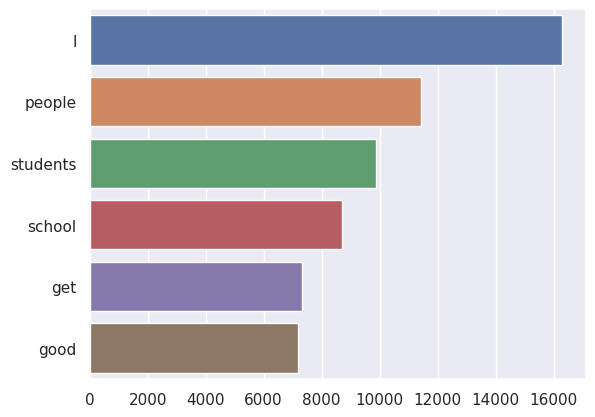

In [13]:
from typing import Counter

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:35]:
    if (word not in stopwords):
        x.append(word)
        y.append(count)

sns.barplot(x=y, y=x, palette='deep')

In [14]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range =(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, index]) 
                    for word, index, in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:10]

<AxesSubplot: >

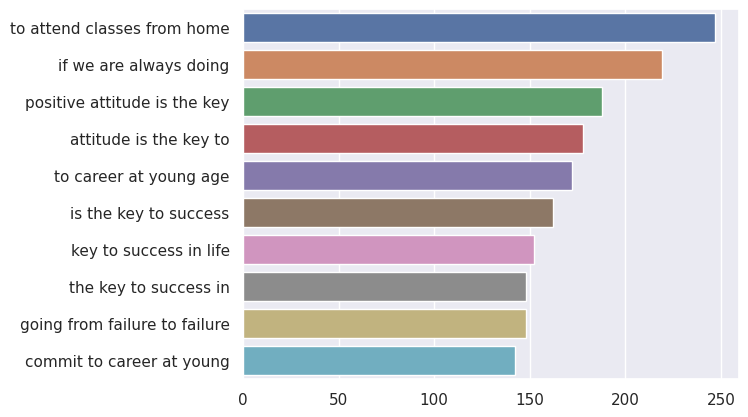

In [15]:
top_n_bigrams = get_top_ngram(train['full_text'], 5)[:10]
x, y = map(list, zip(*top_n_bigrams))
sns.barplot(x = y, y = x, palette="deep")

In [16]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

In [17]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
full_text = train['full_text']
full_text = CleanFeatures(full_text)

In [19]:
full_text

0       I think students would benefit learning homebe...
1       When problem change let best matter happening ...
2       Dear Principal If u change school policy grade...
3       The best time life become I agree greatest acc...
4       Small act kindness impact people change people...
                              ...                        
3906    I believe using cellphones class education us ...
3907    Working alone students argue decission proyect...
3908    A problem chance best What I think quote cant ...
3909    Many people disagree Albert Schweitzers quote ...
3910    Do think failure main thing people consist goa...
Name: full_text, Length: 3911, dtype: object

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2f4f67ec-8ee7-457f-9dd1-c26bc82a923b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>